拟合结果: f0=15743.13Hz, Q=9.7244


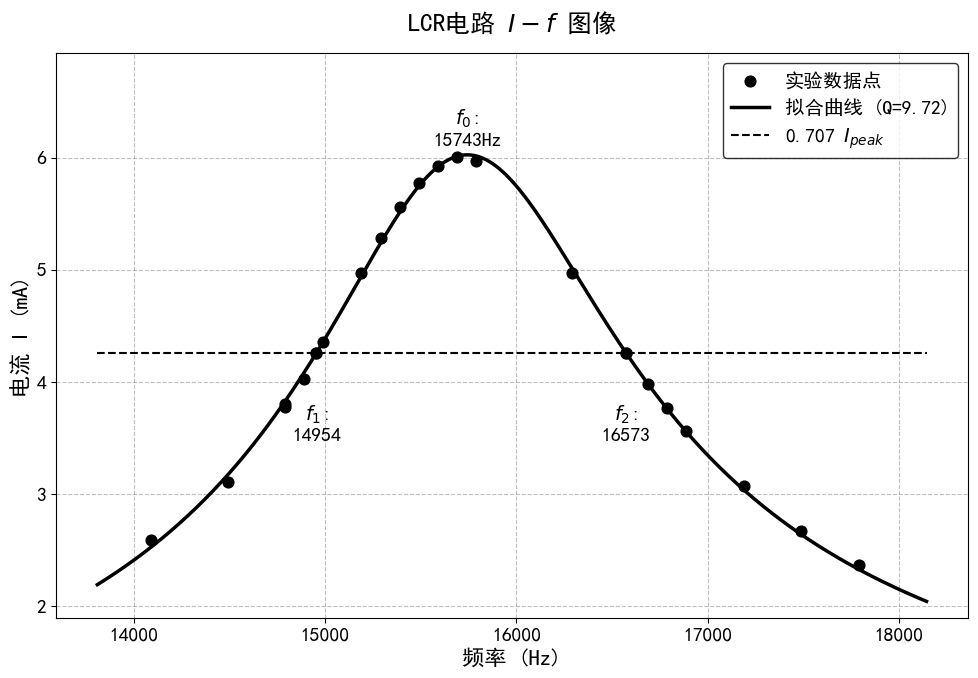

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ================= 1. 数据录入区域 =================
f_data = np.array([16690, 16290, 15790, 15490, 15190, 14790, 14490, 14090, 17190, 17490, 17790, 15690, 15590, 15390, 15290, 14990, 14890, 14790, 16790, 16890])
U_data = np.array([0.398, 0.497, 0.597, 0.577, 0.497, 0.380, 0.311, 0.259, 0.307, 0.267, 0.237, 0.601, 0.593, 0.556, 0.528, 0.436, 0.403, 0.378, 0.377, 0.356])

# R = 100 欧姆
R_load = 100.0
I_data = U_data / R_load

# ================= 2. 核心物理模型 =================
def rlc_current_curve(f, f0, Q, I_peak):
    term = Q * (f / f0 - f0 / f)
    return I_peak / np.sqrt(1 + term**2)

# ================= 3. 拟合计算 =================
max_idx = np.argmax(I_data)
p0_guess = [f_data[max_idx], 5.0, I_data[max_idx]]

try:
    popt, pcov = curve_fit(rlc_current_curve, f_data, I_data, p0=p0_guess)
    f0_fit, Q_fit, I_peak_fit = popt
except Exception as e:
    print(f"拟合失败: {e}")
    exit()

# ================= 4. 计算半功率点 =================
delta_f = f0_fit / Q_fit
f1_fit = np.sqrt(f0_fit**2 + (delta_f/2)**2) - delta_f/2
f2_fit = np.sqrt(f0_fit**2 + (delta_f/2)**2) + delta_f/2
bandwidth_fit = f2_fit - f1_fit

# ================= 5. 输出数据 (控制台) =================
print("="*45)
print(f"拟合结果: f0={f0_fit:.2f}Hz, Q={Q_fit:.4f}")
print("="*45)

# ================= 6. 绘图 (黑白风格 & 大字体) =================
# 数据转换
f_smooth = np.linspace(min(f_data)*0.98, max(f_data)*1.02, 2000) # 稍微加宽一点X轴范围
I_smooth = rlc_current_curve(f_smooth, *popt)

I_data_mA = I_data * 1000
I_smooth_mA = I_smooth * 1000
I_peak_mA = I_peak_fit * 1000
cutoff_val_mA = I_peak_mA / np.sqrt(2)

plt.figure(figsize=(10, 7)) #稍微加大一点画布

# 设置全局字体大小，防止标签太小
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 1. 画实验数据点 (黑色散点)
plt.scatter(f_data, I_data_mA, color='black', s=60, label='实验数据点', zorder=5)

# 2. 画拟合曲线 (黑色实线)
plt.plot(f_smooth, I_smooth_mA, color='black', linewidth=2.5, label=f'拟合曲线 (Q={Q_fit:.2f})')

# 3. 画 0.707 截断线 (黑色虚线)
plt.hlines(cutoff_val_mA, min(f_smooth), max(f_smooth), linestyles='dashed', colors='black', linewidth=1.5, label='0.707 $I_{peak}$')

# 4. 标记关键点 (黑色圆点)
plt.plot([f1_fit, f2_fit], [cutoff_val_mA]*2, 'o', color='black', markersize=8)

# 5. 添加文本标注 (黑色文本)
# 这里稍微调整了位置偏移，并设置了 ha='center' (水平居中)
text_offset_y = I_peak_mA * 0.05 # 动态计算偏移量

# f1 标注
plt.text(f1_fit, cutoff_val_mA - text_offset_y*1.5, f'$f_1$:\n{f1_fit:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')

# f2 标注
plt.text(f2_fit, cutoff_val_mA - text_offset_y*1.5, f'$f_2$:\n{f2_fit:.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')

# f0 标注 (放在峰值上方)
plt.text(f0_fit, I_peak_mA + text_offset_y*0.2, f'$f_0$:\n{f0_fit:.0f}Hz', 
         ha='center', va='bottom', color='black', fontsize=14, fontweight='bold')

# 设置标题和坐标轴标签 (字体加大)
plt.title('LCR电路 $I-f$ 图像', fontsize=18, pad=15, color='black')
plt.xlabel('频率 (Hz)', fontsize=16, color='black')
plt.ylabel('电流 I (mA)', fontsize=16, color='black')

# 刻度字体加大
plt.tick_params(axis='both', which='major', labelsize=14, colors='black')

# 设置 Y 轴范围：留出顶部空间，防止 f0 标注跑出去
# 底部留一点空间，顶部留 15% 的余量
plt.ylim(min(I_data_mA)*0.8, I_peak_mA * 1.15)

# 图例 (去掉边框，纯黑白风格)
plt.legend(loc='best', fontsize=14, edgecolor='black', labelcolor='black')

plt.grid(True, which='both', linestyle='--', alpha=0.5, color='gray') # 网格线可以用深灰色，不抢眼
plt.tight_layout()

plt.show()